# Tech Layoffs EDA

This workbook relates to the Exploratory Data Analysis of the Tech Layoffs dataset from kaggle.

# Initial Hypothesis

Based on reporting and understanding of Tech Layoffs over the last few years, my initial hypothesis is below:

* 1. FAANG Companies will account for the largest percentage of tech layoffs
* 2. San Francisco will account for the largest proportion of tech layoffs by region based on the same hypothesis above.
* 3. Based on layoff magnitude (the percentage of layoffs related to employees) and frequency, the FAANG companies will demonstrate worse long-term hiring practices over the last few years

### Analysing Layoff Magnitude and Frequency

It will be interesting to analyse the magnitude and frequency of tech layoffs in these companies, as it will help to indicate which firms have better long-term hiring. planning and budgeting practices. You would expect companies with better planning and hiring practices to have lower proportional layoffs based on percentage of workforce, as well as lower frequency layoffs over this time period. I will be interesting to see if FAANG companies will be accounted for in this category.

In [10]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data Loading

In [3]:
df = pd.read_csv('tech_layoffs_til_Q1_2024.csv', delimiter=';')
df.head()

,Nr.,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
0,1,3,ShareChat,Bengaluru,India,Asia,200.0,2023-12-20,15.0,1333.0,1133.0,Consumer,Series H,$1700,2023,12.97194,77.59369
1,2,4,InSightec,Haifa,Israel,Asia,100.0,2023-12-19,20.0,500.0,400.0,Healthcare,Unknown,$733,2023,32.81841,34.98850
2,3,6,Enphase Energy,San Francisco Bay Area,USA,North America,350.0,2023-12-18,10.0,3500.0,3150.0,Energy,Post-IPO,$116,2023,37.54827,-121.98857
3,4,7,Udaan,Bengaluru,India,Asia,100.0,2023-12-18,10.0,1000.0,900.0,Retail,Unknown,NaN,2023,12.97194,77.59369
4,5,14,Cruise,San Francisco Bay Area,USA,North America,900.0,2023-12-14,24.0,3750.0,2850.0,Transportation,Acquired,$15000,2023,37.77493,-122.41942


In [4]:
df.columns

Index(['Nr.', '#', 'Company', 'Location_HQ', 'Country', 'Continent',
       'Laid_Off', 'Date_layoffs', 'Percentage', 'Company_Size_before_Layoffs',
       'Company_Size_after_layoffs', 'Industry', 'Stage',
       'Money_Raised_in_$_mil', 'Year', 'lat', 'lng'],
      dtype='object')

### 1.1 Data Preprocessing

First going to analyse the dtypes of the various columns.

In [5]:
df.dtypes

Nr.                              int64
#                                int64
Company                         object
Location_HQ                     object
Country                         object
Continent                       object
Laid_Off                       float64
Date_layoffs                    object
Percentage                     float64
Company_Size_before_Layoffs    float64
Company_Size_after_layoffs     float64
Industry                        object
Stage                           object
Money_Raised_in_$_mil           object
Year                             int64
lat                            float64
lng                            float64
dtype: object

Most of the dtypes are consistent with what I would expect to see; Laid_Off are numeric, Industry/Stage and strings and therefore represented as objects etc. I'll just analyse the distribution of the Laid_Off values, as these will be crucial in analysing the tech layoffs across Companies, Region and Sector.

### 1.2 Investigating missing columns

There is one missing value for Company, so this value will just be removed. In order to evaluate the impact of the other missing values, I will need to calculate the percentage of each column which is missing.

First step is to check for missing values.

There seem to be quite a few missing values. These will be investigated in the next section.

In [5]:
df.isna().sum()

Nr.                              0
#                                0
Company                          1
Location_HQ                      0
Country                          0
Continent                        0
Laid_Off                       107
Date_layoffs                     0
Percentage                     102
Company_Size_before_Layoffs    161
Company_Size_after_layoffs     136
Industry                         0
Stage                            0
Money_Raised_in_$_mil           76
Year                             0
lat                              0
lng                              0
dtype: int64

In [6]:
def print_missing_percentage(df: pd.DataFrame, col_name: str) -> float:
    mask = (df[col_name].isna())
    len_missing = len(df[mask])
    len_df = len(df)
    percentage_missing = (len_missing / len_df) * 100.0
    print(f"col_name: {col_name}, missing (%): {percentage_missing}")
    return percentage_missing

In [7]:
missing_cols = ['Laid_Off', 'Percentage', 'Company_Size_before_Layoffs', 'Company_Size_after_layoffs', 'Money_Raised_in_$_mil']

In [8]:
missing_percentages = [print_missing_percentage(df, col) for col in missing_cols]

col_name: Laid_Off, missing (%): 6.399521531100478
col_name: Percentage, missing (%): 6.100478468899522
col_name: Company_Size_before_Layoffs, missing (%): 9.629186602870814
col_name: Company_Size_after_layoffs, missing (%): 8.133971291866029
col_name: Money_Raised_in_$_mil, missing (%): 4.545454545454546


Overall, I would say that the missing values to Laid_Off are the most significant, as the main goal of the dataset is to evaluate layoffs. Given this, I will most just remove these missing values, and then rerun the missing percentages to see how this has impacted to missing proportions.

In [9]:
missing_laid_off_mask = (df['Laid_Off'].isna())

In [10]:
df = df[~missing_laid_off_mask]

In [11]:
df.isna().sum()

Nr.                             0
#                               0
Company                         0
Location_HQ                     0
Country                         0
Continent                       0
Laid_Off                        0
Date_layoffs                    0
Percentage                     54
Company_Size_before_Layoffs    54
Company_Size_after_layoffs     53
Industry                        0
Stage                           0
Money_Raised_in_$_mil          58
Year                            0
lat                             0
lng                             0
dtype: int64

This has resulted in a significant change in the proportion of missing values. The Percentage, Company_Size_before_Layoffs and Company_size_after_layoffs have all basically halved. I will now recalculate the missing percentages based on the new data distribution.

In [12]:
missing_percentages = [print_missing_percentage(df, col) for col in missing_cols]

col_name: Laid_Off, missing (%): 0.0
col_name: Percentage, missing (%): 3.450479233226837
col_name: Company_Size_before_Layoffs, missing (%): 3.450479233226837
col_name: Company_Size_after_layoffs, missing (%): 3.386581469648562
col_name: Money_Raised_in_$_mil, missing (%): 3.706070287539936


The missing percentages are now around 3%, which is acceptable for removal. However, it is worth analysing these missing datasets to better understand what might be the cuase. My hunch is that the majority of missing data for Percentage and Company_Size will be accounted for by startups, as established companies need to report this data to shareholders.

Based on this, I will created a mask in an attempt to separate between these types of companies.

In [13]:
missing_data_mask = ((df['Percentage'].isna()) | (df['Company_Size_before_Layoffs'].isna()) 
                     | (df['Company_Size_after_layoffs'].isna()))

In [14]:
missing_data_df = df[missing_data_mask]
missing_data_df

,Nr.,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
1408,1409,3274,Orbotech,Yavne,Israel,Asia,100.0,2024-03-19,NaN,NaN,0.0,Manufact…,Acquired,NaN,2024,31.876886,34.738297
1411,1412,3277,Flock Freight,San Diego,USA,North America,54.0,2024-03-16,NaN,NaN,NaN,Logistics,Series D,$399,2024,32.715710,-117.164720
1412,1413,3278,Chipper Cash,San Francisco Bay Area,USA,North America,20.0,2024-03-15,NaN,NaN,NaN,Finance,Series C,$302,2024,37.774930,-122.419420
1444,1445,3310,PropertyGuru,Singapore,Singapore,Asia,79.0,2024-02-27,NaN,NaN,NaN,Real Estate,Post-IPO,$676,2024,1.289670,103.850070
1447,1448,3313,WayCool,Chennai,India,Asia,70.0,2024-02-26,NaN,NaN,NaN,Food,Unknown,$363,2024,13.087840,80.278470
1449,1450,3315,Redesign Health,New York City,USA,North America,77.0,2024-02-23,NaN,NaN,NaN,Healthcare,Series C,$315,2024,40.714270,-74.005970
1450,1451,3316,Carbon Health,San Francisco Bay Area,USA,North America,56.0,2024-02-23,NaN,NaN,NaN,Healthcare,Series D,$522,2024,37.774930,-122.419420
1452,1453,3318,Affirm,Pittsburgh,USA,North America,60.0,2024-02-21,NaN,NaN,NaN,Finance,Post-IPO,$1.500,2024,40.440620,-79.995890
1456,1457,3322,Aptiv,Krakow,Poland,Europe,250.0,2024-02-20,NaN,NaN,NaN,Transport…,Post-IPO,$8,2024,50.061947,19.936856
1473,1474,3339,Redesign Health,New York City,USA,North America,77.0,2024-02-13,NaN,NaN,NaN,Healthcare,Unknown,$315,2024,40.714270,-74.005970


In [15]:
print(f"Length of missing data: {len(missing_data_df)}")

Length of missing data: 54


In [16]:
missing_data_df['Company'].unique()

array(['Orbotech', 'Flock Freight', 'Chipper Cash', 'PropertyGuru',
       'WayCool', 'Redesign Health', 'Carbon Health', 'Affirm', 'Aptiv',
       'Pure Storage', 'Grammarly', 'Amazon', 'BillGO', 'Illumina',
       'Trove Recommer…', 'CircleCI', 'Thinx', 'TechCrunch',
       'DispatchHealth', 'Microsoft', 'Amperity', 'Personio', 'Cure.fit',
       'GoStudent', 'GoTo', 'Seedr', 'Xendit', 'TikTok', 'YouTube',
       'Sirplus', 'Veeam', 'GrabCAD', 'New Work SE', 'Cloudflare',
       'Google', 'IAC', 'Beam Benefits', 'Instagram', 'Branch',
       'Uber Freight', 'The Messenger', 'Paytm', 'Intel', 'Checkout.com',
       'Arm Holdings', 'eBay', 'Glowforge', 'Solarisbank',
       'Analog Devices', 'ForgeRock', 'Flex', 'TomTom'], dtype=object)

It looks like my initial theory was incorrect, as there seem to be alot of established companies (Instagram, Google, Microsoft) in the above list. On further reflection, it could be the case that the dataset is not up to date, as all of the entries which have missing values are from with last 3-4 months (December 2023 onwards). I will create a mask which filters the dataset based on the earliest entry in these missing values, to determine whether this is the case.

In [17]:
earliest_date = min(missing_data_df['Date_layoffs'])
earliest_date

'2023-12-12'

So the earliest entry in this missing dataset is 12/12/2023, so I will filter the original dataset based on this to determine if there is still missing data.

In [18]:
date_mask = (df['Date_layoffs'] < earliest_date)

In [19]:
filtered_df = df[date_mask]
filtered_df.isna().sum()

Nr.                             0
#                               0
Company                         0
Location_HQ                     0
Country                         0
Continent                       0
Laid_Off                        0
Date_layoffs                    0
Percentage                      0
Company_Size_before_Layoffs     0
Company_Size_after_layoffs      0
Industry                        0
Stage                           0
Money_Raised_in_$_mil          38
Year                            0
lat                             0
lng                             0
dtype: int64

Money_raised is now the only column which has missing values. I will take a quick look at the distribution of these missing entries.

In [20]:
filtered_df[filtered_df['Money_Raised_in_$_mil'].isna()]

,Nr.,#,Company,Location_HQ,Country,Continent,Laid_Off,Date_layoffs,Percentage,Company_Size_before_Layoffs,Company_Size_after_layoffs,Industry,Stage,Money_Raised_in_$_mil,Year,lat,lng
11,12,38,Navan,San Francisco Bay Area,USA,North America,145.0,2023-12-05,5.000000,2900.0,2755.0,Finance,Unknown,NaN,2023,37.44188,-122.14302
49,50,200,Epic Games,Raleigh,USA,North America,870.0,2023-09-28,16.000000,5438.0,4568.0,Consumer,Unknown,NaN,2023,35.77210,-78.63861
73,74,276,Zebra Technologies,Chicago,USA,North America,700.0,2023-08-28,7.000000,10000.0,9300.0,Manufacturing,Post-IPO,NaN,2023,41.85003,-87.65005
90,91,342,Discord,San Francisco Bay Area,USA,North America,37.0,2023-08-03,4.000000,925.0,888.0,Consumer,Series H,NaN,2023,37.77493,-122.41942
124,125,456,FNZ,London,United Kingdom,Europe,1000.0,2023-07-06,15.000000,6667.0,5667.0,Finance,Private Equity …,NaN,2023,51.50853,-0.12574
195,196,661,Sabre,Dallas,USA,North America,1100.0,2023-05-04,15.000000,7333.0,6233.0,Travel,Post-IPO,NaN,2023,32.78306,-96.80667
377,378,1103,Glovo,Barcelona,Spain,Europe,250.0,2023-01-30,6.000000,4167.0,3917.0,Food,Acquired,NaN,2023,41.38879,2.15899
378,379,1104,Delivery Hero,Berlin,Germany,Europe,156.0,2023-01-30,4.000000,3900.0,3744.0,Food,Post-IPO,NaN,2023,52.52437,13.41053
404,405,1173,Swiggy,Bengaluru,India,Asia,380.0,2023-01-20,6.000000,6333.0,5953.0,Food,Unknown,NaN,2023,12.97194,77.59369
415,416,1207,Vroom,New York City,USA,North America,275.0,2023-01-18,20.000000,1375.0,1100.0,Transportation,Post-IPO,NaN,2023,40.71427,-74.00597


Overall, I don't think that this is an important feature, so will just remove it.

So to summarise, the below filtering will be applied to the dataframe to resolve missing entries:

* 1. Filter entries prior to 12/12/2023
* 2. Remove any missing Money_raised columns

In [21]:
earliest_date = min(missing_data_df['Date_layoffs'])
to_remove_mask = ((df['Date_layoffs'] < earliest_date) & (~df['Money_Raised_in_$_mil'].isna()))

In [22]:
df = df[to_remove_mask]
df.isna().sum()

Nr.                            0
#                              0
Company                        0
Location_HQ                    0
Country                        0
Continent                      0
Laid_Off                       0
Date_layoffs                   0
Percentage                     0
Company_Size_before_Layoffs    0
Company_Size_after_layoffs     0
Industry                       0
Stage                          0
Money_Raised_in_$_mil          0
Year                           0
lat                            0
lng                            0
dtype: int64

## 2. Data Analysis

For starters, I will analyse the distribution of Laid_Off and do some groupings based on Company and Region to analyse the distribution of layoffs based on these filters.


### 2.1 Analysing distribution of Laid_Off

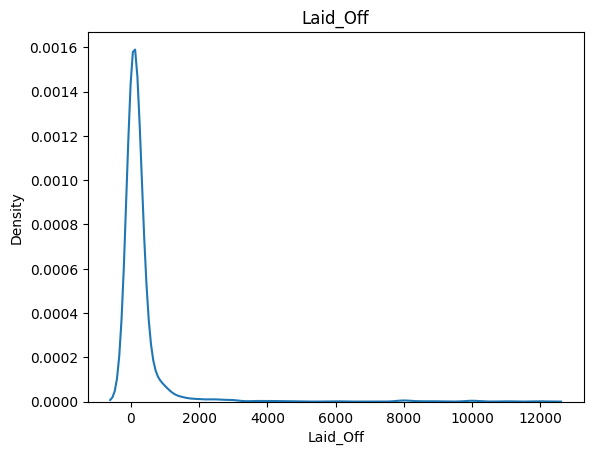

In [9]:
sns.kdeplot(x=df['Laid_Off'])
plt.title('Laid_Off')
plt.show()

The above plot indicates that there is a positive skew within the Laid_Off dataset, which is expected as initial hypothesis is that the majority of tech layoffs were accounted for by a small concentration of Companies (FAANG).

### 2.2 Analysing Company Layoffs by Company

Now I intend to analyse which companies have the better hiring practices, based on analysing the magnitude and frequency of layoffs over the last few years.

In [23]:
df['Company'].value_counts()

Company
Gopuff               5
Blend                5
Chipper Cash         4
FrontRow             4
Pear Therapeutics    4
                    ..
&Open                1
Cisco                1
Wayflyer             1
Lokalise             1
Tamara Mellon        1
Name: count, Length: 1093, dtype: int64

There do seem to be quite a few multiple entries for companies, so I need to come up with a method for aggregating based on the company.

In [40]:
grouped_df = df.groupby(['Company', 'Location_HQ']).agg({
    'Laid_Off': 'sum',
    'Industry': 'first',
    'Country': 'first',
    'Stage': 'first',
    }).reset_index()
grouped_df

,Company,Location_HQ,Laid_Off,Industry,Country,Stage
0,#Paid,Toronto,19.0,Marketing,Canada,Series B
1,&Open,Dublin,9.0,Marketing,Ireland,Series A
2,10X Genomics,San Francisco Bay Area,100.0,Healthcare,USA,Post-IPO
3,1stdibs,New York City,70.0,Retail,USA,Series D
4,23andMe,San Francisco Bay Area,146.0,Healthcare,USA,Post-IPO
...,...,...,...,...,...,...
1095,iFit,Logan,300.0,Fitness,USA,Private Equity …
1096,iFood,Sao Paulo,355.0,Food,Brazil,Subsidi…
1097,iPrice Group,Kuala Lumpur,50.0,Retail,Malaysia,Unknown
1098,iRobot,Boston,225.0,Consumer,USA,Acquired


Now I think it is worth adding in some extra columns to describe how many times layoffs were made, and what the average size was, the date of first and last layoffs to describe size and frequency of layoffs over the last few years.

In [41]:
grouped_df['Num_Layoffs'] = df.groupby(['Company', 'Location_HQ']).size().values
grouped_df.sort_values(by=['Laid_Off', 'Num_Layoffs'], ascending=False, inplace=True)

In [42]:
grouped_df.head()

,Company,Location_HQ,Laid_Off,Industry,Country,Stage,Num_Layoffs
39,Amazon,Seattle,27150.0,Retail,USA,Post-IPO,4
593,Meta,San Francisco Bay Area,21000.0,Consumer,USA,Post-IPO,2
398,Google,San Francisco Bay Area,12000.0,Consumer,USA,Post-IPO,1
797,SaleSan Franciscoorce,San Francisco Bay Area,10000.0,Sales,USA,Post-IPO,3
598,Microsoft,Seattle,10000.0,Other,USA,Post-IPO,1


In [44]:
grouped_df.describe()

,Laid_Off,Num_Layoffs
count,1100.000000,1100.000000
mean,316.751818,1.233636
std,1314.585867,0.553716
min,3.000000,1.000000
25%,37.750000,1.000000
50%,85.000000,1.000000
75%,198.500000,1.000000
max,27150.000000,5.000000


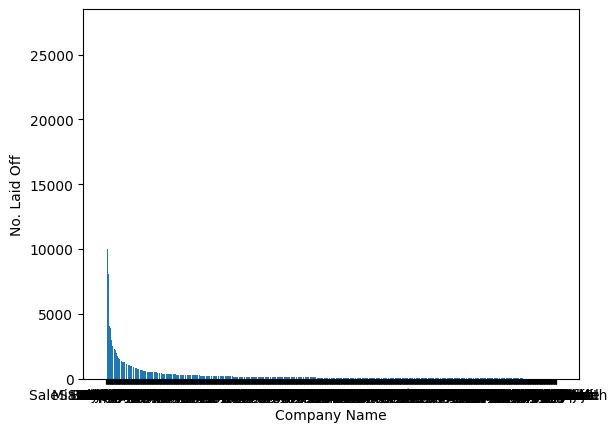

In [43]:
companies = grouped_df['Company']
laid_off = grouped_df['Laid_Off']
fig = plt.bar(companies, laid_off)
plt.xlabel('Company Name')
plt.ylabel('No. Laid Off')
plt.show()